In [1]:
#confusion matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import cv2
import itertools
from PIL import Image
import scipy.ndimage

In [2]:
im = Image.open('test_5_GT_4x_gland_tumor.png')

In [3]:
def rgb2label(img, color_codes=None):
    """Converts a PIL RGB image to an indexed labelmap.
    Given an image of size (h,w,3) -- an RGB image -- this function creates a
    numpy array of size (h,w) where each pixel is replaced with an index listed
    in `color_codes`. The input image should be a pixel labelmap with a small
    number of discrete rgb values. The indices of color_codes should be between
    [0, C-1] where C is the number of classes.
    Args:
        img: A PIL image.
        color_codes: A dict where each key is an rgb tuple, and the
            corresponding value is the index to replace.
    Returns:
        A numpy array containing class indices instead of RGB values.
    """
    if color_codes is None:
        raise ValueError('You must provide a color_code dictionary mapping RGB values to index values.')

    # Pull the RGB tuple from the PIL image
    vals = list(img.getdata())
    #vals = im.tolist()
    h, w = np.shape(img)[:2]

    # If we've received RGBA values, remove the last pixel from each tuple
    if img.mode == 'RGBA':
        assert type(vals[0]) == tuple, 'Mask is RGBA type, but pixels are not tuples'
        vals = [x[:-1] for x in vals]

    # Create a placeholder for the index labelmap, set to 0
    result = np.ndarray(shape=(h, w), dtype=int)
    result[:, :] = 0

    for rgb, idx in color_codes.items():
        # Test each tuple
        vals_bin = [v == rgb for v in vals]
        vals_bin = np.reshape(vals_bin, (h, w))

        # Replace the location in the result image with the index value
        result[vals_bin] = idx


    return result

In [4]:
dictionary = {
                (0, 255, 0): 7,     #tumor bud
                (255, 0, 0): 4,     #RBCs
                (128, 0, 0): 6,     #stroma
                (0, 255, 255): 5,   #smooth muscle
                (255, 255, 0): 2,   #lymphocyte
                #(0, 0, 128): 3,     #mucin
                (0, 128, 0): 1,     #epithelial cell
                (0, 0, 0): 0,       #white background
                (255, 0, 255): 8    #tumor tissue
            }

In [5]:
im = rgb2label(im, dictionary)

In [6]:
print(np.shape(im))

(4800, 4800)


In [7]:
from collections import Iterable
def flatten(lis):
     for item in lis:
         if isinstance(item, Iterable):
             for x in flatten(item):
                 yield x
         else:        
             yield item

In [8]:
im = im.tolist()

im = list(flatten(im))

In [9]:
print(np.shape(im))

(23040000,)


In [21]:
w = pd.read_excel('tumorbudclassifier_more_pred_e40_0.01_0.01_sn_3_0.95g_0.8t.xlsx', sheetname='Sheet1', header=None) #if the first cell is Nan, write 7 to it first

nrows = 600
ncols = 600

w = np.array(w, dtype=np.int)
w = np.reshape(w,(nrows, ncols))

w = scipy.ndimage.zoom(w, 8, order=0)  #'Resampled by a factor of 8 with nearest interpolation'

C:\Users\chenyusu\Anaconda3\lib\site-packages\pandas\io\excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


In [22]:
w = w.astype(int)
w = w.tolist()
w = list(flatten(w))

In [23]:
print(np.unique(w))

[0 1 2 4 5 6 7 8]


In [24]:
y_true = im
y_pred = w

Normalized confusion matrix
[[5.62e-01 1.16e-01 1.68e-02 1.39e-02 3.11e-02 1.47e-01 1.36e-03 1.12e-01]
 [2.87e-03 8.64e-01 6.77e-03 6.72e-04 6.25e-03 8.05e-02 2.27e-02 1.64e-02]
 [6.23e-04 8.65e-02 6.63e-01 6.75e-03 1.33e-02 1.62e-01 6.69e-02 1.95e-04]
 [1.83e-02 7.89e-02 8.71e-03 7.36e-01 5.53e-02 8.43e-02 1.63e-03 1.67e-02]
 [4.02e-03 8.95e-03 1.34e-02 4.10e-03 7.77e-01 1.82e-01 1.02e-02 9.74e-04]
 [1.91e-02 1.27e-01 5.28e-02 6.90e-03 3.04e-01 4.25e-01 3.47e-02 3.05e-02]
 [0.00e+00 1.11e-02 1.38e-01 0.00e+00 1.56e-02 3.04e-01 3.78e-01 1.53e-01]
 [1.43e-03 3.74e-02 2.15e-02 9.39e-04 9.72e-03 1.34e-01 5.27e-02 7.42e-01]]


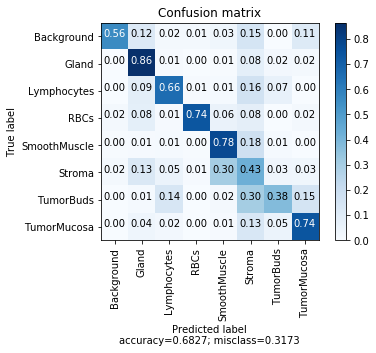

In [25]:
cm = confusion_matrix(y_true, y_pred)

accuracy = np.trace(cm) / float(np.sum(cm))
misclass = 1 - accuracy

#cm = np.load('C:/Users/chenyusu/CRCproject/CRC_pytorch_chenyu/src/cm_tumorbud_60.npy')

class_names = ['Background', 'Gland', 'Lymphocytes', 'RBCs', 'SmoothMuscle', 'Stroma', 'TumorBuds', 'TumorMucosa']
#class_names = [0,1,2,3,4,5,6,7,8]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    

    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    #plt.tight_layout()
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=class_names,
                      #title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)

#df_cm = pd.DataFrame(cm, range(9), range(9))
#sn.set(font_scale=1.4)#for label size
#sn.heatmap(df_cm, annot=True, fmt='d',annot_kws={"size": 16}, xticklabels=['Background', 'Epithelial', 'Lymphocytes', 'Mucin', 'RBCs', 'SmoothMuscle', 'Stroma', 'TumorBuds', 'TumorMucosa'], yticklabels=['Background', 'Epithelial', 'Lymphocytes', 'Mucin', 'RBCs', 'SmoothMuscle', 'Stroma', 'TumorBuds', 'TumorMucosa'])# font size
#plt.show()
plt.savefig('cm_tumorbud_4x_sn_3_0.95g_0.8t_e40_0.01_0.01.png', bbox_inches='tight', dpi=1000)